In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)

model_name = '20221127_btc_one_h12_shift'

In [2]:
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC'] # binance, bybit, okex
symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'AVAX'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP'] # binance, bybit

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv_5m',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df = dfs[0]
    shift_min = 50
    df['timestamp'] = (df['timestamp'] - pd.to_timedelta(shift_min, unit='minute')).dt.floor('1H') + pd.to_timedelta(shift_min, unit='minute')
    df['symbol'] = df['symbol'].str.replace('USDT', '')
    
    g = df.groupby(['timestamp', 'symbol'])
    df = pd.concat([
        g['op'].nth(0),
        g['cl'].nth(-1),
        g['cl'].mean().rename('twap_5m'),
        g['hi'].max(),
        g['lo'].min(),
        g['volume'].sum(),
    ], axis=1)
    
    df = df.sort_index()
    return df

df = merge_data(dfs)

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    
    train_provider_configs = [
        {
            'provider': 'bigquery',
            'options': {
                'table': 'kraken_historical_ohlcvt',
                'symbols': symbols,
            }
        },
    ]

    dfs = DataFetcher(memory=get_joblib_memory()).fetch(
        provider_configs=train_provider_configs, 
        min_timestamp=None,
    )
    df_kraken = dfs[0].set_index(['timestamp', 'symbol'])

    df = df.copy()
    df['extended'] = False
    df = pd.concat([df, df_kraken])
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()

# df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_shift.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,buy_amount,twap,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2022-11-24 11:05:00+00:00,ADAUSDT,0.31280,0.31310,0.31250,0.31280,1696681.0,5.308006e+05,878.0,641880.0,2.008068e+05,0.312800,0.000100,0.000122,0.312980,0.312680,0.000180,-0.000120,0.000959,1.083144e-06
1,2022-11-25 14:35:00+00:00,ADAUSDT,0.31270,0.31330,0.31250,0.31310,963618.0,3.014109e+05,639.0,681212.0,2.131121e+05,0.312860,0.000305,0.000249,0.312980,0.312660,0.000160,-0.000160,0.001023,1.185355e-06
2,2022-11-26 23:30:00+00:00,ADAUSDT,0.31340,0.31350,0.31250,0.31310,1408211.0,4.405842e+05,936.0,556584.0,1.741401e+05,0.313020,0.000217,0.000261,0.313180,0.312780,0.000140,-0.000260,0.001278,1.674823e-06
3,2022-11-27 01:00:00+00:00,ADAUSDT,0.31260,0.31320,0.31250,0.31310,1438323.0,4.501062e+05,827.0,718405.0,2.248215e+05,0.312980,0.000110,0.000141,0.313040,0.312760,0.000200,-0.000080,0.000895,8.989489e-07
4,2022-11-25 14:20:00+00:00,ADAUSDT,0.31260,0.31290,0.31250,0.31280,982949.0,3.073697e+05,686.0,561734.0,1.756712e+05,0.312760,0.000114,0.000195,0.312840,0.312580,0.000160,-0.000100,0.000831,7.158901e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2839397,2021-02-20 08:40:00+00:00,MATICUSDT,0.18282,0.18799,0.18100,0.18450,15332711.0,2.833584e+06,11699.0,7415709.0,1.372000e+06,0.185394,0.001432,0.001755,0.186430,0.183706,0.001408,-0.001316,0.014729,2.257071e-04
2839398,2021-02-19 22:50:00+00:00,MATICUSDT,0.14551,0.15526,0.14550,0.15505,16296669.0,2.461412e+06,11735.0,9119274.0,1.378958e+06,0.151288,0.003029,0.000336,0.151806,0.148934,0.002402,-0.000470,0.019073,3.771971e-04
2839399,2021-03-12 13:25:00+00:00,MATICUSDT,0.44557,0.44616,0.42177,0.43306,12081512.0,5.216559e+06,11735.0,5184934.0,2.239441e+06,0.433874,0.007164,0.007973,0.439140,0.431084,0.002696,-0.005360,0.018619,4.903798e-04
2839400,2021-03-11 21:15:00+00:00,MATICUSDT,0.37091,0.38399,0.36913,0.37568,22731543.0,8.549815e+06,20471.0,11083532.0,4.171777e+06,0.377024,0.002586,0.003700,0.379526,0.372912,0.003474,-0.003140,0.017562,3.230010e-04


op          cl       twap_5m  \
timestamp                 symbol                                         
2019-09-08 17:50:00+00:00 BTC     10000.0000  10000.0000  10000.000000   
2019-09-08 18:50:00+00:00 BTC     10000.0000  10344.0400  10231.027500   
2019-09-08 19:50:00+00:00 BTC     10358.5000  10351.8300  10350.598333   
2019-09-08 20:50:00+00:00 BTC     10351.4200  10329.8000  10343.060833   
2019-09-08 21:50:00+00:00 BTC     10391.9300  10389.1200  10392.418333   
...                                      ...         ...           ...   
2022-11-27 01:50:00+00:00 ETC        19.9660     19.9610     19.963000   
                          ETH      1212.0000   1210.5400   1211.065000   
                          LINK        7.1400      7.1220      7.131500   
                          MATIC       0.8470      0.8455      0.845900   
                          XRP         0.3979      0.3975      0.397600   

                                          hi          lo       volume  
timestamp                 symbol                                       
2019-09-08 17:50:00+00:00 BTC     10000.0000  10000.0000        0.002  
2019-09-08 18:50:00+00:00 BTC     10357.5300  10000.0000      364.251  
2019-09-08 19:50:00+00:00 BTC     10368.6400  10338.3800      582.176  
2019-09-08 20:50:00+00:00 BTC     10357.2300  10324.7700      691.067  
2019-09-08 21:50:00+00:00 BTC     10412.6500  10355.8000      667.361  
...                                      ...         ...          ...  
2022-11-27 01:50:00+00:00 ETC        19.9980     19.9350    35124.410  
                          ETH      1213.6400   1209.9300    22714.709  
                          LINK        7.1490      7.1210   241608.040  
                          MATIC       0.8478      0.8453   903896.000  
                          XRP         0.3981      0.3972  2363786.300  

[236628 rows x 6 columns]

In [3]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype
from joblib import Parallel, delayed

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(delayed(calc_features_single)(df_symbol))
        # dfs.append(calc_features_single(df_symbol))
    dfs = Parallel(n_jobs=-1)(dfs)
    df = pd.concat(dfs).sort_index()
    
    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
        
    dfs_parallel = []
    def func_parallel1(col):
        feature_mean = beta_mean(df, col)
        return [
            (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    for col in get_feature_columns(df):
        dfs_parallel.append(delayed(func_parallel1)(col))
    for res in Parallel(n_jobs=-1)(dfs_parallel):
        dfs += res
    
    df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0).clip(-1, 1)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0).clip(-1, 1)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    # for t_center in [2, 4, 6, 12, 24]:
    for t_center in [4, 6, 12, 24, 36, 48, 72, 96]:
    # for t_center in [6, 12, 24, 36, 48, 72, 96]:
    # for t_center in [3, 6, 8, 12, 18, 24, 36, 48, 72, 96]:
    # for t in [2, 4, 8, 16]:
    # for t in [2, 4, 8, 16, 32, 64]:
        dfs2 = []
        t_shifts = [0]
        # t_shifts = [-1, 0, 1]
        for t_shift in t_shifts:
            t = t_center + t_shift
            
            feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
            feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
            feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

            feature_stoch_k, feature_stoch_d = stoch(t)
            feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
            feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

            feature_stochf_k, feature_stochf_d = stochf(t)
            feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
            feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

            feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
            feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
            feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

            feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))

            ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

            dfs2 += [
                adx(t).rename('feature_adx_{}'.format(t)),
                adxr(t).rename('feature_adxr_{}'.format(t)),
                feature_rsi,
                rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
                rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
                aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
                aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
                aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
                # cci(t).rename('feature_cci_{}'.format(t)),
                # cmo(t).rename('feature_cmo_{}'.format(t)),
                dx(t).rename('feature_dx_{}'.format(t)),
                mfi(t).rename('feature_mfi_{}'.format(t)),
                # trix(t).rename('feature_trix_{}'.format(t)),
                # feature_integ_std,
                # feature_std,
                # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
                # feature_mom,
                # atr(t).rename('feature_atr_{}'.format(t)),
                # natr(t).rename('feature_natr_{}'.format(t)),
                range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
                # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
                # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
                # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
                volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
                range_pos(t).rename('feature_range_pos_{}'.format(t)),
                range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
                # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
                obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
                ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
                # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
                # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
                feature_stoch_k,
                feature_stoch_d,
                (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
                (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
                feature_stochf_k,
                feature_stochf_d,
                (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
                (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
                feature_stochrsi_k,
                feature_stochrsi_d,
                (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
                (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
                ultosc(t).rename('feature_ultosc_{}'.format(t)),
                volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
                skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
                # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
                (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
                feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
                (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
                # dimension less but not bounded
                # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
                # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
                # zscore(t).rename('feature_zscore_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
                # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
                # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
            ]
            
        feature_count = len(dfs2) // len(t_shifts)
        for j in range(feature_count):
            for i in range(1, len(t_shifts)):
                dfs2[j] += dfs2[j + feature_count * i]
            dfs2[j] /= len(t_shifts)
        dfs += dfs2[:feature_count]

    return pd.concat(dfs, axis=1)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
import lightgbm as lgb
import numpy as np
import pandas as pd

class NonstationaryFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, remove_count=None, remove_ratio=None):
        if remove_count and remove_ratio:
            raise Exception('remove_count and remove_ratio cannot be set simultaneously')
        self.estimator = lgb.LGBMRegressor(n_jobs=-1, random_state=1) if estimator is None else estimator
        self.remove_count = remove_count
        self.remove_ratio = remove_ratio

    def fit(self, X, y=None):
        X = self._validate_data(X)
        
        if self.remove_count:
            remove_count = self.remove_count
        else:
            remove_count = int(self.remove_ratio * X.shape[1])
            
        mem = get_joblib_memory()
        self.selected_features_ = mem.cache(nfr_calc_features)(self.estimator, remove_count, X)

        return self

    def transform(self, X, y=None):
        X = self._validate_data(X)

        return X[:, self.selected_features_].copy()

    def inverse_transform(self, X, y=None):
        raise Exception('inverse_transform not implemented')

        
def nfr_calc_features(model, remove_count, X):
    model = clone(model)
    model.fit(X, np.arange(X.shape[0]))
    importances = model.feature_importances_

    features = list(range(X.shape[1]))
    feature_imp = pd.DataFrame(zip(importances, features), columns=['value', 'feature'])
    feature_imp = feature_imp.sort_values('value')

    for i in range(X.shape[1] - remove_count, X.shape[1]):
        features.remove(int(feature_imp['feature'].iloc[i]))

    return np.array(features)

In [5]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor, StackingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV
import catboost

class ExampleModelRank:
    def __init__(self):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        self._model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            # colsample_bytree=0.9,
            colsample_bytree=0.03,
            subsample=0.5,
            subsample_freq=1,
            # lambda_l2=1e1,
            random_state=1,
            n_jobs=-1,
        )
        
        # self._model = catboost.CatBoostRegressor(
        #     n_estimators=100,
        #     # learning_rate=0.01,
        #     # depth=4,
        #     rsm=0.03,
        #     # has_time=True,
        #     # eval_metric=CorrMetric(),
        #     # early_stopping_rounds=10,
        #     random_state=1,
        #     # boosting_type='Plain',
        #     loss_function='RMSEWithUncertainty',
        #     posterior_sampling=True,
        #     verbose=False,
        # )
        
        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        # self._model = BaggingRegressor(
        #     self._model,
        #     # n_estimators=40, 
        #     random_state=1
        # )
        # self._model = VotingRegressor([
        #     ('lgbm1', self._model),
        #     # ('lgbm2', lgbm2),
        #     # ('lgbm1', BaggingRegressor(self._model, n_estimators=1, random_state=1)),
        #     # ('lgbm2', BaggingRegressor(lgbm2, n_estimators=1, random_state=2)),
        #     # ('lgbm3', BaggingRegressor(lgbm3, n_estimators=1, random_state=3)),
        #     # ('lgbm3', lgbm3),
        # ])
        
        # self._model = RidgeCV(cv=5)
        
        # self._model = StackingRegressor(
        #     [
        #         ('lgbm1', self._model),
        #         ('lgbm3', lgbm3),
        #         ('ridge', RidgeCV(cv=5)),
        #     ], 
        #     final_estimator=RidgeCV(cv=5),
        #     cv=5,
        # )
        
        self._model = Pipeline([
            ('remove_nonstationary1', NonstationaryFeatureRemover(
                estimator=nonstationary_est,
                remove_ratio=0.1,
            )),
            ('remove_nonstationary2', NonstationaryFeatureRemover(
                estimator=nonstationary_est,
                remove_ratio=0.1,
            )),
            # ('remove_nonstationary3', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     remove_ratio=0.1,
            # )),
            # ('remove_nonstationary_dcor', SelectPercentile(
            #     score_func=feature_selector_dcor_t,
            #     percentile=50,
            # )),
            ('model', self._model)
        ])
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.provider_configs = provider_configs
        self.merge_data = merge_data
        self.horizon = 12

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df, 'ret_train')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        # y = df['ret_beta']
        # y = np.sign(y) * np.log(1 + np.abs(y))
        # y = np.sign(y) * np.log(1 + 10 * np.abs(y))
        
        df['ret_beta_abs'] = df['ret_beta'].abs()
        df['ret_beta_abs_sum'] = df.groupby('timestamp')['ret_beta_abs'].transform('sum')
        y = df['ret_beta'] / (1e-37 + df['ret_beta_abs_sum'])
        
        # self._model.fit(df[features], y)
        # return self._model.fit(df[features], np.sign(df['ret_beta']), sample_weight=np.abs(df['ret_beta']))
        # self._model.fit(df[features], np.sign(y), sample_weight=np.abs(y))
        self._model.fit(df[features], np.sign(y), model__sample_weight=np.abs(y))
        # self._model.fit(df[features], np.sign(y) * np.abs(y) ** 0.5, model__sample_weight=np.abs(y) ** 0.5)
        # self._model.fit(df[features], np.sign(y) / (1e-5 + np.abs(y)), model__sample_weight=np.abs(y) ** 2)
        # self._model.fit(df[features], np.sign(y) / (1e-7 + np.abs(y) ** 2), model__sample_weight=np.abs(y) ** 3)
        # return self._model.fit(df[features], np.sign(df['ret']), model__sample_weight=np.abs(df['ret']))
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features])
        # preds = self._model.virtual_ensembles_predict(
        #     df[features], 
        #     prediction_type='TotalUncertainty', 
        #     virtual_ensembles_count=10
        # )
        
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] = np.sign(y_pred) * np.abs(y_pred) ** 0.5
        # df['position'] = np.sign(y_pred) * np.abs(y_pred) ** 2
        # df['position'] *= df['position'].abs() > 0.1
        idx_btc = df.index.get_level_values('symbol') == 'BTC'
        df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        
        df['position_beta'] = df['position'] * df['beta']
        df['position_btc'] = -df.groupby('timestamp')['position_beta'].transform('sum')
        df.loc[idx_btc, 'position'] = df.loc[idx_btc, 'position_btc']
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        
        # df['feature_vola'] = df.groupby('symbol')['cl'].transform(lambda x: x.rolling(24).std() / x).fillna(0)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

/tmp/ipykernel_12/2016807699.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/2016807699.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (192354, 833)


/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.16s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_features)(self.estimator, remove_count, X)
/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.05s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_f

fit df.shape (167496, 833)


/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.02s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_features)(self.estimator, remove_count, X)
/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 0.89s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_f

fit df.shape (157011, 833)


/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 0.94s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_features)(self.estimator, remove_count, X)
/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 0.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_f

fit df.shape (157002, 833)


/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 0.95s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_features)(self.estimator, remove_count, X)
/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 0.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_f

fit df.shape (157227, 833)


/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 0.94s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_features)(self.estimator, remove_count, X)
/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 0.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_f

return without cost statistics
mean 0.002056650849328368
std 0.011239981366692912
sharpe 0.18297635754297403
double sharpe 1.6554437036982181
max drawdown 1.343518159326461
min -0.08168955697715738
min sharpe 0.025176423100243567
return with cost statistics
mean 0.0011573434548944033
std 0.011243649137725603
sharpe 0.10293308166395826
double sharpe 0.8124311433756384
max drawdown 2.0335888399418316
min -0.08268953859972643
min sharpe 0.013996250003240824


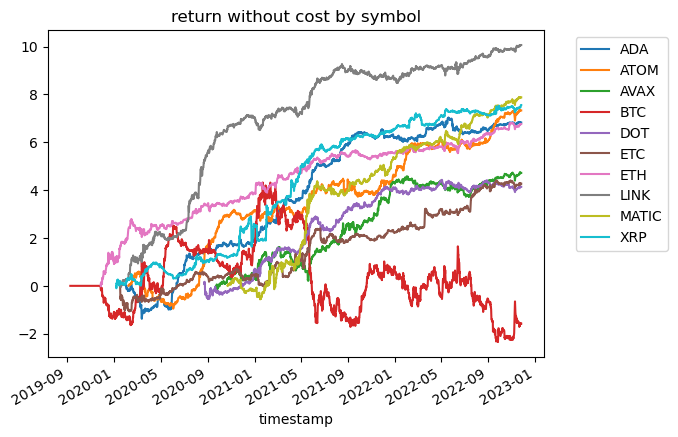

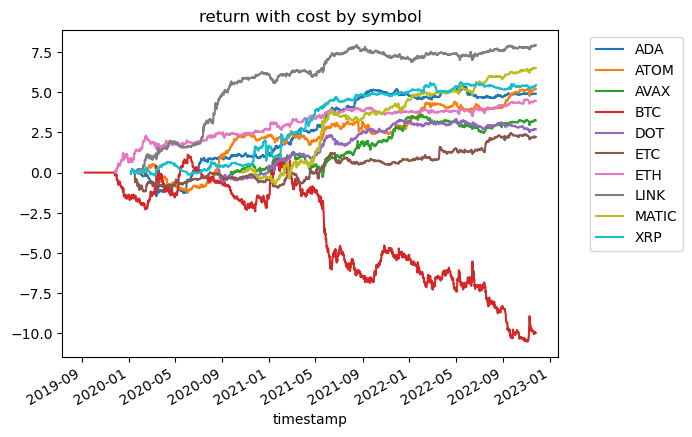

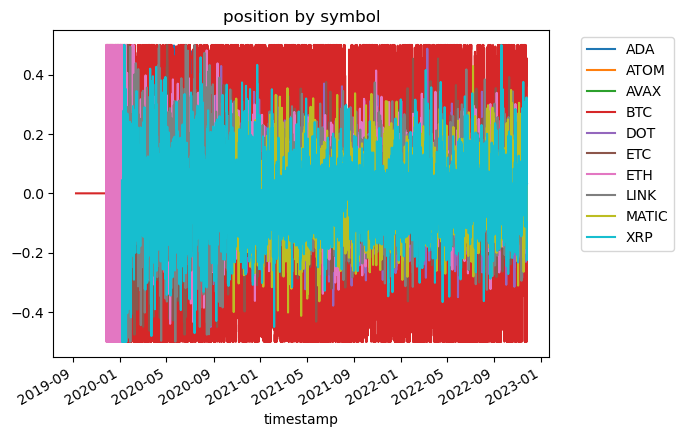

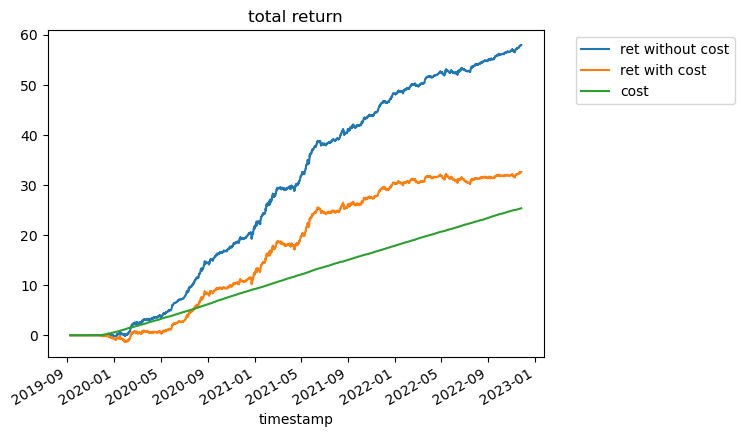

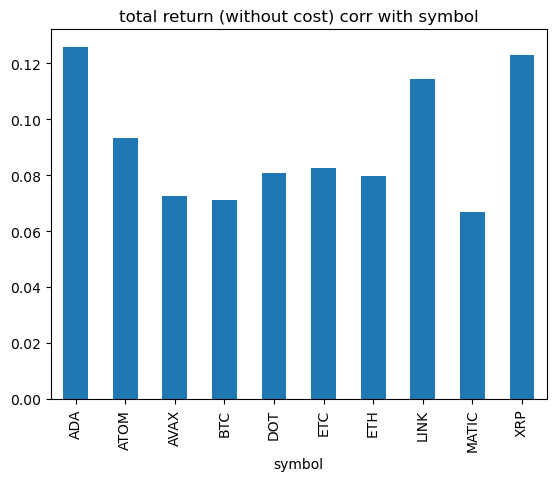

/tmp/ipykernel_12/2016807699.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/2016807699.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (208185, 833)


/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.26s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_features)(self.estimator, remove_count, X)
/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.12s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_f

In [6]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_shift.pkl')
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-26 00:00:00Z')]
# df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]

df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-12 - 1) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]

model = ExampleModelRank()

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna(), horizon=12)
# visualize_result(df_cv.loc[~df['extended']].dropna(), horizon=12)

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/{}.xz'.format(model_name), 'wb') as f:
    f.write(data)

expt

- [20221104_btc_one_h12/20221108_224508.ipynb](20221104_btc_one_h12/20221108_224508.ipynb) without hedge
- [20221104_btc_one_h12/20221108_224536.ipynb](20221104_btc_one_h12/20221108_224536.ipynb) with hedge
- [20221104_btc_one_h12/20221109_005418.ipynb](20221104_btc_one_h12/20221109_005418.ipynb) with hedge, lgbm 100 * bagging 100, subsample 0.5
- [20221104_btc_one_h12/20221109_112941.ipynb](20221104_btc_one_h12/20221109_112941.ipynb) with hedge, subsample 0.5
- [20221104_btc_one_h12/20221109_113019.ipynb](20221104_btc_one_h12/20221109_113019.ipynb) with hedge, subsample 0.5, l2 1e1
- [20221104_btc_one_h12/20221109_113046.ipynb](20221104_btc_one_h12/20221109_113046.ipynb) with hedge l2 1e1
- these are evaluated with horizon 4 (wrong setting)
- the latest version is evaluated with horizon 12
- current: with hedge, subsample 0.5 <- new baseline

- [20221104_btc_one_h12/20221110_013653.ipynb](20221104_btc_one_h12/20221110_013653.ipynb) new baseline <- good
- [20221104_btc_one_h12/20221109_215052.ipynb](20221104_btc_one_h12/20221109_215052.ipynb) y shrink
- [20221104_btc_one_h12/20221109_221350.ipynb](20221104_btc_one_h12/20221109_221350.ipynb) y^0.5, y^0.5
- [20221104_btc_one_h12/20221109_220049.ipynb](20221104_btc_one_h12/20221109_220049.ipynb) 1/y, y^2
- [20221104_btc_one_h12/20221109_220641.ipynb](20221104_btc_one_h12/20221109_220641.ipynb) 1/y^2, y^3
- [20221104_btc_one_h12/20221110_013729.ipynb](20221104_btc_one_h12/20221110_013729.ipynb) y timestamp normalized
- [20221104_btc_one_h12/20221110_014924.ipynb](20221104_btc_one_h12/20221110_014924.ipynb) y timestamp normalized, y raw

expt2

- [20221104_btc_one_h12/20221122_162656.ipynb](20221104_btc_one_h12/20221122_162656.ipynb) (evaluated with horizon 24)
- [20221104_btc_one_h12/20221123_130232.ipynb](20221104_btc_one_h12/20221123_130232.ipynb)
- [20221104_btc_one_h12/20221123_130343.ipynb](20221104_btc_one_h12/20221123_130343.ipynb) 2018
- [20221104_btc_one_h12/20221123_130245.ipynb](20221104_btc_one_h12/20221123_130245.ipynb) -ltc
- [20221104_btc_one_h12/20221123_130350.ipynb](20221104_btc_one_h12/20221123_130350.ipynb) -ltc 2018
- [20221104_btc_one_h12/20221123_130257.ipynb](20221104_btc_one_h12/20221123_130257.ipynb) -ltc+avax selected
- [20221104_btc_one_h12/20221123_130358.ipynb](20221104_btc_one_h12/20221123_130358.ipynb) -ltc+avax 2018

expt 3 shift (todo: remove)

- [20221127_btc_one_h12_shift/20221127_111719.ipynb](20221127_btc_one_h12_shift/20221127_111719.ipynb) shift 0
- [20221127_btc_one_h12_shift/20221127_111756.ipynb](20221127_btc_one_h12_shift/20221127_111756.ipynb) shift 5
- [20221127_btc_one_h12_shift/20221127_111805.ipynb](20221127_btc_one_h12_shift/20221127_111805.ipynb) shift 10
- [20221127_btc_one_h12_shift/20221127_111813.ipynb](20221127_btc_one_h12_shift/20221127_111813.ipynb) shift 15
- [20221127_btc_one_h12_shift/20221127_111822.ipynb](20221127_btc_one_h12_shift/20221127_111822.ipynb) shift 20
- [20221127_btc_one_h12_shift/20221127_111830.ipynb](20221127_btc_one_h12_shift/20221127_111830.ipynb) shift 25
- [20221127_btc_one_h12_shift/20221127_111842.ipynb](20221127_btc_one_h12_shift/20221127_111842.ipynb) shift 30
- [20221127_btc_one_h12_shift/20221127_111854.ipynb](20221127_btc_one_h12_shift/20221127_111854.ipynb) shift 35
- [20221127_btc_one_h12_shift/20221127_111905.ipynb](20221127_btc_one_h12_shift/20221127_111905.ipynb) shift 40
- [20221127_btc_one_h12_shift/20221127_111913.ipynb](20221127_btc_one_h12_shift/20221127_111913.ipynb) shift 45
- [20221127_btc_one_h12_shift/20221127_111923.ipynb](20221127_btc_one_h12_shift/20221127_111923.ipynb) shift 50
- [20221127_btc_one_h12_shift/20221127_111933.ipynb](20221127_btc_one_h12_shift/20221127_111933.ipynb) shift 55

expt 3 shift

- 

/tmp/ipykernel_12/2016807699.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/2016807699.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


timestamp                  symbol
2022-09-28 01:50:00+00:00  ADA       0.055953
                           ATOM      0.058034
                           AVAX      0.052235
                           BTC      -0.500000
                           DOT       0.050315
                                       ...   
2022-11-27 01:50:00+00:00  ETC      -0.065172
                           ETH      -0.011610
                           LINK     -0.030948
                           MATIC    -0.062906
                           XRP       0.009730
Name: position, Length: 14410, dtype: float64
['ADA', 'ATOM', 'AVAX', 'BTC', 'DOT', 'ETC', 'ETH', 'LINK', 'MATIC', 'XRP']
test shift predict


/tmp/ipykernel_12/2016807699.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/2016807699.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0
/tmp/ipykernel_12/2016807699.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fr

position1  position2  position3
timestamp                 symbol                                 
2022-09-28 02:50:00+00:00 ADA      0.080933   0.080933   0.050795
                          ATOM     0.041670   0.041670   0.056108
                          AVAX     0.060115   0.060115   0.057499
                          BTC     -0.500000  -0.500000  -0.500000
                          DOT      0.062752   0.062752   0.056684
...                                     ...        ...        ...
2022-11-27 00:50:00+00:00 ETC     -0.062916  -0.062916  -0.062916
                          ETH     -0.004340  -0.004340  -0.004340
                          LINK     0.009177   0.009177   0.009177
                          MATIC   -0.089956  -0.089956  -0.089956
                          XRP      0.124727   0.124727   0.124727

[14390 rows x 3 columns]

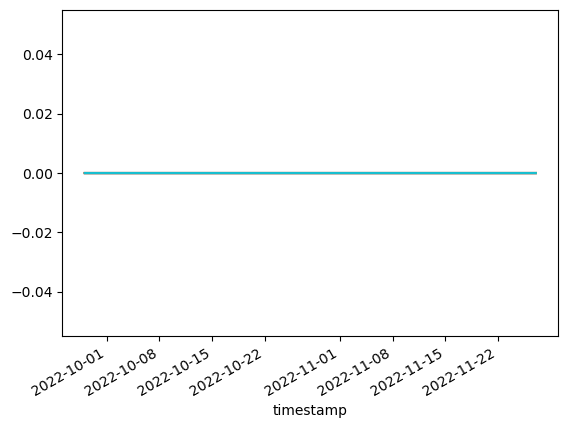

ADA (1439, 4)
ATOM (1439, 4)
AVAX (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETC (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
MATIC (1439, 4)
XRP (1439, 4)


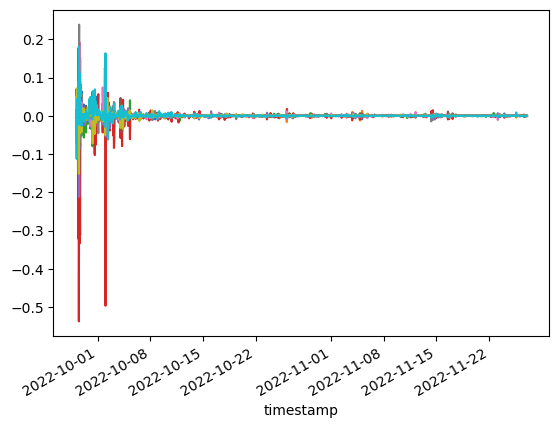

In [7]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/{}.xz'.format(model_name))
df = pd.read_pickle('/tmp/df_binance_ohlcv_shift.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()